# EEC206 Lab 2 Documention
_Hui-Ying Siao_, _Spencer Bagga_


## Part 1 Image Formation, Image Processing, Image Filtering 

<em>Part of this lab is based on that from Dr. Ordonez from University of Virginia</em><br/><br/>

In this lab we will apply our knowledge in the lectures on Image Enhancement through a series of excercises focused on practical skills to build more complex applications.

### 1. Image Processing: Enhancing an Image to Make it Look Better

In this section we will write functions to augment or reduce the brightness of an image and create a vignette effect. First, code below is provided to load an RGB image into a numpy array with 3 dimensions.


### Part 1.1
Brightening the image is achieved by simply multiplying the RGB values by the desired brightness factor. 
However, since the maximum R, G, or B value is 255 we have to make sure that any RGB value after brightening the image does not exceed that maximum value.
To account for this, any pixels that exceed 255 when muliplied by the factor are scaled to 255/factor.
The ensures that when we multiply by the brightness factor no value will exceed 255.
Anything that would have exceeded the 255 limit will then be changed to 255 and anything that would not have exceed will be multiplied by the brightness factor. 

Image height:  416  width:  600


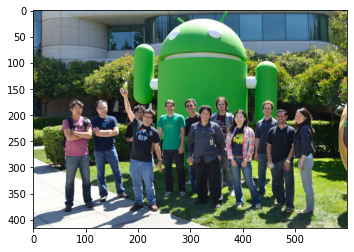

In [ ]:
from PIL import Image
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen

img_url = 'https://drive.google.com/uc?export=view&id=11ckrrCVnKq8oD0ATWRddwfR0308r3bpw'
#img = sp.misc.imread(urlopen(img_url), mode = 'RGB')
img = Image.open(urlopen(img_url))

# Show the image size.
print('Image height: ', img.height,' width: ',img.width)

# Plot the image.
def display_image(img):
  plt.figure()
  plt.imshow(img)
  plt.grid(False)
  plt.show()
  
display_image(img)

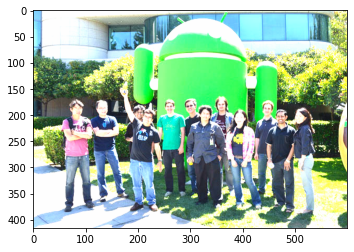

In [ ]:
img = np.array(img) # convert image to numpy array

FACTOR = 2

def brighten_image(img, factor):
  if factor < 1:
    print("Factor should be greater than 1")
    return -1
  bright_image = np.copy(img)
  bright_image[bright_image > 255/factor] = 255/factor # anything greater than max/factor gets set to max/factor to avoid overflow
  bright_image = bright_image * factor # multiply the image by factor
  return bright_image

  
bright_image = brighten_image(img,FACTOR)
display_image(bright_image)

### Part 1.2
We are going to implement here a vignette effect similar to the one on Instagram when you go to Edit -> Vignette. The basic idea is to make things on the boundary of the image darker and leave the pixels near the center of the image almost unchanged. We are providing below an output of what the resulting image should look like. 

In this section we are to apply a vignette to an image. 
The vignette should scale down the intestity of the pixels that are closer to the image edge more so than the pixels that are in the center of the image.
To accomplish this, an "apply_vignette" function is defined.
Within this function we created a 2D scaling matrix that is the same size as the input image.
Since the image intensity needs to be scaled more around the edges of the image than at the center, we interpreted this as a Gaussian distribution.
This 2D matrix is created by first generating two 1D matrices which have the length of the image row count and column count.
Each of these 1D matrices has a maximum value at their center point.
These 1D arrays are then sent to through a Gaussian distribution. 
This is not completely necessary but it smooths the transition between the highly scales and unscaled regions. 
It also allows for the user to control the how intense the scaling is depending on the value of sigma that is specified (large sigma will have less scaling while small sigma will have more intense scaling).
To create the 2D scaling matrix, the two 1D matrices are multiplied. 
The 2D matrix is then normalized and mutliplied the input image.
The function returns the result of this multiplication which is the image with vignette applied. 

On Google Colab, the run time for the "apply_vignette" function is rougly 10ms. 
This means it would be able to satisfy a live video feed of roughly 100Hz or 100 frames per second (fps).
We think this would be fast enough for a real time implementation.

We were assisted in creating this function from the following link. OpenCV2 also has a getGaussianKernel function but that was not utilized for sake the of demonstration.

**References:** https://stackoverflow.com/questions/22654770/creating-vignette-filter-in-opencv

0.007737874984741211


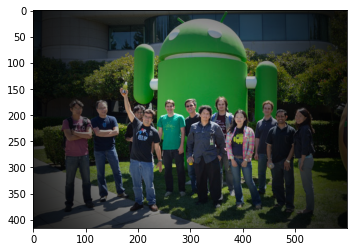

In [ ]:
import math
import time

# function to get a gaussian distribution of coefficients for the row and column
def get_coefficients(size, sigma):
  # if, else builds a 1D array of values the increase, reach a max in the middle of array, then decrease
  if size % 2: # if odd
    k = np.linspace(1, size, (size//2)+1)
    kt = k[::-1] # reverse the order of the array 
    i = np.append(k,kt) # append the reversed array 
    i = np.rint(i) # round to nearest int 
  else: # else even
    k = np.linspace(1,size,int(size/2))
    k = np.rint(k)
    kt = k[::-1]
    i = np.append(k,kt)
    i = np.rint(i)
    
  G = 1/(math.sqrt(2*math.pi)*sigma)*np.exp(-((i-(size-1))/2)**2/(2*sigma**2))
  G = G.reshape((size, 1))
  return G
  
def apply_vignette(img, sigma):
  vig_img = np.copy(img) # create a copy of the image to edit 
  vig_img[:,:,:] = 0 # set everything to zero
  rows, cols, dim = img.shape[:3] # unpack the dimensions
  col_coeffs = get_coefficients(cols, sigma) # get the column coefficients 
  row_coeffs = get_coefficients(rows, sigma) # get the row coefficients 
  mat_coeffs = row_coeffs * col_coeffs.T # create a matrix of the coefficients
  norm_coeffs = mat_coeffs / mat_coeffs.max() # normalize so that middle is 1 and edges scale down

  for j in range(dim):
    vig_img[:,:,j] = img[:,:,j] * norm_coeffs # scale R, G, B

  return vig_img


start_time = time.time()
vignette_image = apply_vignette(img,170) # apply the vignette with sigma of 170
print('Time for the vignette effect:', time.time()-start_time, '(s)')
display_image(vignette_image)

## Part 2 Image Filtering: Convolving Images 

Here we will experiment with image filtering through the convolution operator. These are operations where your output depends on a neighborhood of pixels as opposed to one-to-one pixel mapping eas we did in the previous section. We will use the same image as before but now will be working on grayscale.


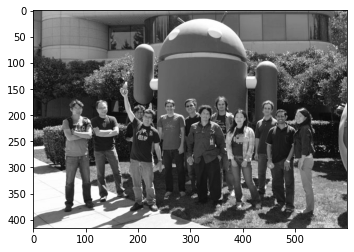

In [ ]:
import scipy as sp
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
from PIL import Image
import math
import time

# Try maybe downloading the image in case the CS webserver goes down.
img_url = 'http://www.cs.virginia.edu/~vicente/images/google_android.jpg'
# img = misc.imread(urlopen(img_url), mode = 'RGB')
img = np.asarray(Image.open(urlopen(img_url)))

# Converting image to grayscale.
img = img.astype('float')
img = (img[:, :, 0] + img[:, :, 1] + img[:, :, 2]) / 3.0

# Plot the image.
def display_image(img):
  plt.figure()
  plt.gray()
  plt.imshow(img)
  plt.grid(False)
  plt.show()

display_image(img)

### Part 2.1  
In this section, a Gaussian function is applied on the image to generate Gaussian blur. 
While the sigma is larger, the image gets more blurry. 
The reason is because the intensity between different frequencies is lower when the sigma is larger. 
Gaussian blur can also be used as a low pass filter because it reduces the high frequency signals. 
Here in the implementation, ax is the number of the pixels in each dimension of x-y axis. 
l is set to 15 representing a filter of 15X15 pixels.

Implement a Gaussian Blur of this image using a square neighborhood of $15\times15$ pixels with $\mu=(0, 0)$ and $\sigma=0.8$. 
Assume a symmetric 2D Gaussian distribution: e.g. $$G(x,y)=\frac{1}{2\pi\sigma^2}e^{-\frac{x^2+y^2}{2\sigma^2}}$$.  



0.17607903480529785


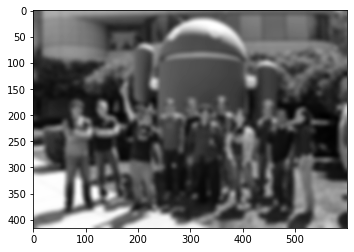

In [ ]:
def apply_gaussian_blur(img, l=15, sig=4):
  ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
  xx, yy = np.meshgrid(ax, ax)
  kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))/(2*np.pi*np.square(sig))
  blurred_img = signal.convolve2d(img, kernel, boundary = 'symm', mode = 'same')
  return blurred_img

start_time = time.time()
blurred_img = apply_gaussian_blur(img)
print('Time for the Gaussian filter:', time.time()-start_time, '(s)')
display_image(blurred_img)


Comments: What happens if $\sigma$ is larger? Does this make the image more blurry or less blurry? Why?

### Part 2.2
Extend your code into to implement a bilateral filter to include the intensity term $$\frac{1}{2\pi\beta^2}e^{-\frac{(f(s,r)-f(x,y))^2}{2\beta^2}}$$ Find the $\beta$ that you believe to have the best tradeoff.  

A bilateral filter is implemented in this section. 
By using a bilateral filter, the spatial and color weights are combined to preserve the weights. 
The bilateral filter is the product of kernel_G and kernel_I. 
The values of kernel_I for different values depend on the pixel intensities, and the pixel intensities are changing with the locations. 
Here in our implentation, kernel_G is the same as the kernel in part 2.1, and kernel_I is related to the instensity of pixels at different locations on the image. 
The best tradeoff is when the beta is 3.5, which prserves the edge of the imgae well. 
F and F1 in the implementation are to expand the size of the original image by zero padding the +- 14 pixels around the image. 

7.876644849777222


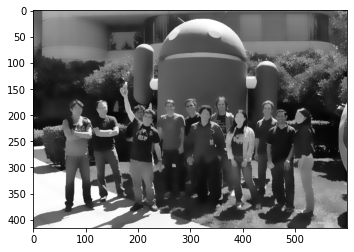

In [ ]:
def bilateral(img):
  l=15
  beta=3.5  # By changing beta, we get the tradeoff = 3.5 which prserves the edge of the imgae well while setting alpha = 10.
  alpha=10  
  ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
  xx, yy = np.meshgrid(ax, ax)
  kernel_G = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(alpha))/(2*np.pi*np.square(alpha)) # Gaussian kernel, same as part 2.1
  F=np.zeros((np.shape(img)[0]+14,np.shape(img)[1]+14)) # F is to expand the size of the original image by zero padding the +- 14 pixels around the image
  F1=np.zeros((np.shape(img)[0]+14,np.shape(img)[1]+14)) #F1 is to expand the size of the original image by zero padding the +- 14 pixels around the image
  F[7:np.shape(img)[0]+7,7:np.shape(img)[1]+7]=img
  kernel_I = np.zeros((15,15))
  
  for i in range(np.shape(img)[0]):
    for j in range(np.shape(img)[1]):
      kernel_I=np.exp(-0.5* (np.square(F[i+7,j+7]-F[i:i+15,j:j+15]) / np.square(beta))/(2*np.pi*np.square(beta))) # Intensity kernel, intensity is changing with the location of the pixels.
      G = kernel_G* kernel_I
      F1[i+7,j+7] = np.sum(G * F[i:i+15,j:j+15])/np.sum(G)
          
  img=F1[7:np.shape(img)[0]+7,7:np.shape(img)[1]+7]
  return img


start_time = time.time()
bilateral_img = bilateral(img)
print('Time for applying the bilateral filter:', time.time()-start_time, '(s)')
display_image(bilateral_img)


### Part 2.3
Here we will display the spatial derivatives (gradients) of the image in the x-axis direction and the y-axis direction by showing the resultant magnitude between the two. Display as an image the magnitude of the gradients at each pixel location. Use the second order Sobel operators studied in class. 

The second order sobel filter is implemented here to convolve with the grayscale image. 
The second order filter is formed by two 1st order filters Kx and Ky, and after the convolution with the original image, two images Ix and Iy are generated. 
G here represents the gradient magnitude of the sobel filter and theta is the direction of the gradient. 

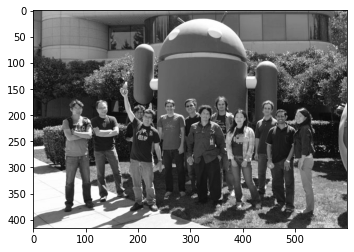

0.05189633369445801


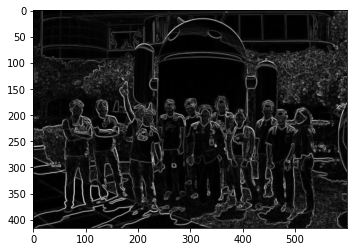

In [ ]:
def sobel_filters(img):
  Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float64)
  Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float64)
  Ix = signal.convolve2d(img, Kx, boundary='symm', mode='same')
  Iy = signal.convolve2d(img, Ky, boundary='symm', mode='same')
  G = np.hypot(Ix, Iy)
  G = G / G.max() * 255
  theta = np.arctan2(Iy, Ix)
  return G



start_time = time.time()
mag = sobel_filters(img)
print('Time for applying the sobel filter:', time.time() - start_time, '(s)')
display_image(img)
display_image(mag)

### Part 2.4

Use the above output to emphasize the boundaries of the objects in the original grayscale image. 

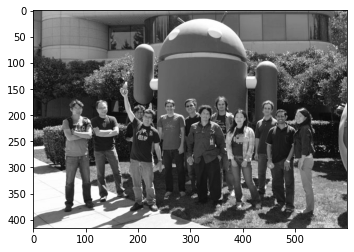

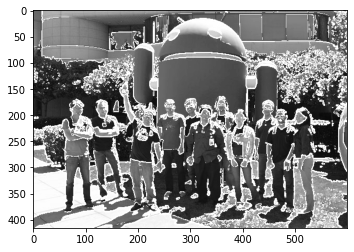

In [ ]:
def emphasize(img, mag):
  emph_img = np.copy(img)
  emph_ind = np.where(mag > 40)
  emph_img[emph_ind] = 255 # change 255 to 0 if you want black outlines instead of white
  return emph_img

emph_img = emphasize(img, mag)  
display_image(img)
display_image(emph_img)

# 3. Exact Histogram Equalization 
Implement a function `exactHistEq(im)` for a grayscale image `im` such that the histogram of the output image is EXACTLY uniform. Test your algorithm by showing the before and after histogram. You can assume that the order of pixel intensities can be resolved by considering neighborhoods no larger than 5x5. You are free to utilize codes found on the web with proper reference and explain how you modify them to suit your need.

0.29464077949523926


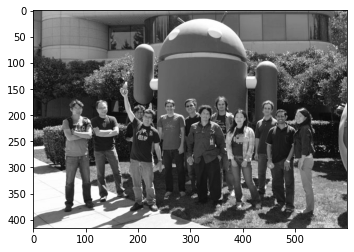

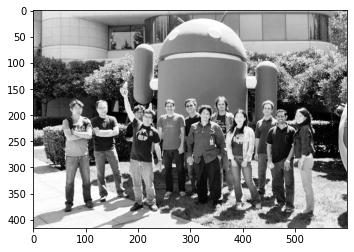

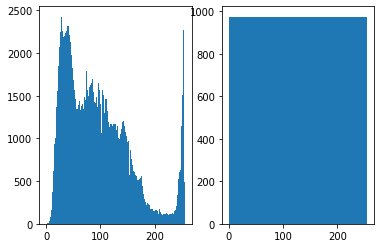

In [ ]:
import numpy as np
import math
from scipy import signal
import time

def exactHistEq(img):
  r, c = img.shape # store the row and column size in a variable
  mat = np.array([[1,1,1,1,1],[1,1,1,1,1],[1,1,0,1,1],[1,1,1,1,1],[1,1,1,1,1]]) # local averaging kernel
  avg = mat/24 # 5x5 - center pixel
  avg_arr = signal.convolve2d(img, avg, mode = "same") # convolve the img with local averaging kernel
  avg_arr = avg_arr/255 # normalize pixel average
  img_avg = img + avg_arr # take the img and each pixel's normalized average to itself
  img_flat = np.ndarray.flatten(img_avg) # flatten the image array
  img_flat_sort = np.argsort(img_flat) # array where the each element corresponds to its index in ascending order
  x = img_flat_sort // c # floor dividing by the columns gives the row number
  y = img_flat_sort % c # remainder of dividing by the columns gives the column number
  equalized_img = np.zeros(img.shape)

  # there is probably a more easily understandable way to do this but this is how i thought of it
  for i in range(len(img_flat_sort)):
    equalized_img[x[i]][y[i]] = i // (len(img_flat_sort)/256)

  return equalized_img 

start_time = time.time() # for timing
equalized_img = exactHistEq(img)
print(time.time()-start_time) # print the time to execute the equalization

# plot the images
display_image(img)
display_image(equalized_img)

# make img 1D for the histogram
img_flat = np.ndarray.flatten(img)
equalized_img_flat = np.ndarray.flatten(equalized_img)

plt.subplot(1, 2, 1)
plt.hist(img_flat, bins=256)
plt.subplot(1, 2, 2)
plt.hist(equalized_img_flat, bins=256)
plt.show()

## 4. Color Segmentation

In lecture, we discussed the idea of using color as a visual cue to identify objects in an image. In my lab, I have a yellow sphere that is used for calibration and one of my experiments has a need to segment out the sphere from the background. The algorithm needs to be robust against variation in illumination, background scene, and imperfections on the sphere surface. As there are other calibration objects with different shapes, the goal is to develop the segmentation based purely on color. Test your algorithm with the following three images. 
![sphere 1](https://drive.google.com/uc?export=view&id=1vYWpzSzUuoCyC6SeNYjmd8ew3SaLeKDY)
![sphere 2](https://drive.google.com/uc?export=view&id=1p_VaPDpXE0n3NuRIdb41RJCejZd98iC4)
![sphere 3](https://drive.google.com/uc?export=view&id=1qqeb16lGb_rr_fGJqXz9aTBIbZwJJf6l)


In [ ]:
import cv2
from google.colab import files
import numpy as np
from scipy.ndimage import morphology
import matplotlib.pyplot as plt
import time

In [ ]:
uploaded = files.upload() 

Saving sunflower2.jpeg to sunflower2.jpeg


0.04484748840332031


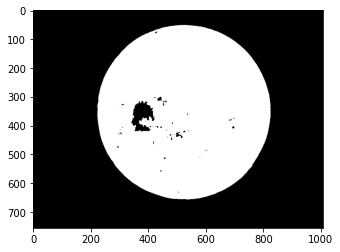

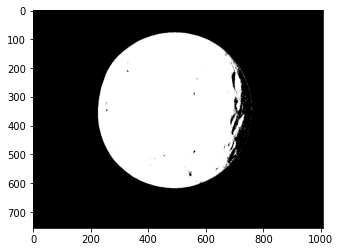

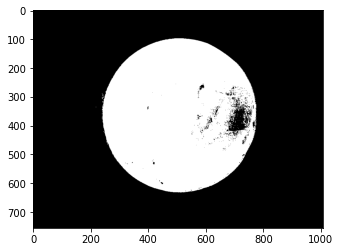

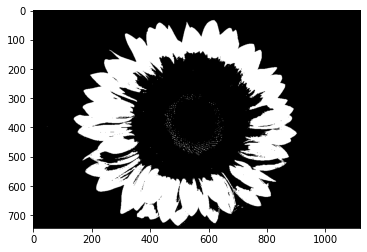

0.03759932518005371


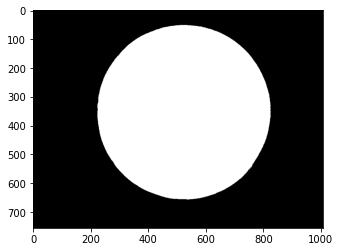

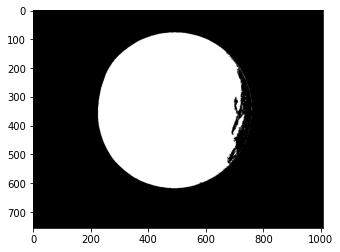

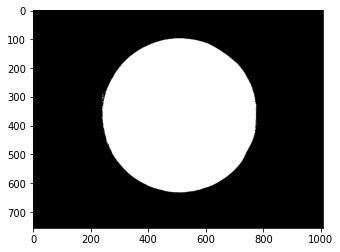

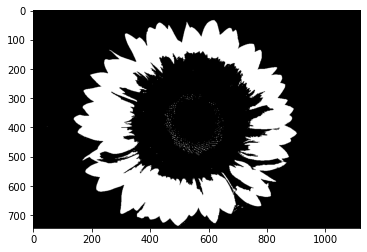

In [ ]:
sphere1 = cv2.imread("sphere1-small.jpg") # change file name as needed 
sphere2 = cv2.imread("sphere2-small.jpg") # change file name as needed
sphere3 = cv2.imread("sphere3-small.jpg") # change file name as needed
test = cv2.imread("sunflower2.jpeg")      # change file name as needed

# put this here so i do not have to keep running the above code sections
def display_image(img):
  plt.figure()
  plt.imshow(img, cmap = 'gray')
  plt.grid(False)
  plt.show()

# this function segments the yellow from an input image and returns a binary
# mask where the yellow is 255 and anything else is 0
def segment_color(img):
  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) # convert from BGR to HSV
  lower_yellow = np.array([21, 86, 84]) # hsv lower bound
  upper_yellow = np.array([35, 255, 255]) # hsv upper bound
  bool_arr = (hsv >= lower_yellow) & (hsv <= upper_yellow) # returns bool array of size hsv_sphere
  segmented_img = np.where(np.all(bool_arr == True, axis=-1), 255, 0) # where the condition is satisfied replace with 255, else 0
  return segmented_img

# this function fills the imperfections or holes on any segmented objects
def fill_imperfection(segmented_img):
  filled_img = morphology.binary_fill_holes(segmented_img) 
  return filled_img


start_time = time.time() # for timing the function
segment1 = segment_color(sphere1)
print(time.time() - start_time) # time for image to be segmented
segment2 = segment_color(sphere2)
segment3 = segment_color(sphere3)
segment4 = segment_color(test)

# displaying segmented images
display_image(segment1)
display_image(segment2)
display_image(segment3)
display_image(segment4)

# filling the imperfections if needed
# filling images is not needed if the color segmentation was able to separate 
# the entire object
start_time = time.time()
filled1 = fill_imperfection(segment1)
print(time.time() - start_time)
filled2 = fill_imperfection(segment2)
filled3 = fill_imperfection(segment3)
filled4 = fill_imperfection(segment4)

#displaying the filled images
display_image(filled1)
display_image(filled2)
display_image(filled3)
display_image(filled4)
